# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [41]:
from ehv.core import plot_gate_zarr

In [3]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq
import pyarrow

## SCIP computed features

In [4]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

In [5]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202111191528/").glob("*.parquet")
], axis=0)

In [6]:
df.shape

(274050, 1774)

In [10]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem[:-8])

In [19]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/wbc/meta/"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [28]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"
df["meta_label"] = df.apply(map_to_class, axis=1)

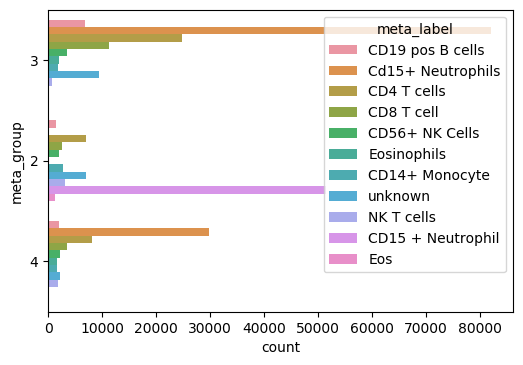

In [22]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_label")

In [23]:
df["meta_label"].value_counts()

Cd15+ Neutrophils    111861
CD15 + Neutrophil     51560
CD4 T cells           39840
unknown               18560
CD8 T cell            17282
CD19 pos B cells      10438
CD56+ NK Cells         7744
CD14+ Monocyte         6207
NK T cells             5775
Eosinophils            3572
Eos                    1211
Name: meta_label, dtype: int64

In [29]:
df.shape

(274050, 1776)

In [30]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202111191528/features.parquet")

## NaN filter

In [31]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(257919, 1776)

In [32]:
df.columns[df.isna().all(axis=0)]

Index(['feat_inertia_tensor_0', 'feat_inertia_tensor_eigvals_0',
       'feat_moments_hu_0', 'feat_inertia_tensor_1',
       'feat_inertia_tensor_eigvals_1', 'feat_moments_hu_1',
       'feat_inertia_tensor_2', 'feat_inertia_tensor_eigvals_2',
       'feat_moments_hu_2', 'feat_inertia_tensor_3',
       'feat_inertia_tensor_eigvals_3', 'feat_moments_hu_3',
       'feat_inertia_tensor_4', 'feat_inertia_tensor_eigvals_4',
       'feat_moments_hu_4', 'feat_inertia_tensor_5',
       'feat_inertia_tensor_eigvals_5', 'feat_moments_hu_5',
       'feat_inertia_tensor_6', 'feat_inertia_tensor_eigvals_6',
       'feat_moments_hu_6', 'feat_inertia_tensor_7',
       'feat_inertia_tensor_eigvals_7', 'feat_moments_hu_7',
       'feat_inertia_tensor_8', 'feat_inertia_tensor_eigvals_8',
       'feat_moments_hu_8', 'feat_inertia_tensor_9',
       'feat_inertia_tensor_eigvals_9', 'feat_moments_hu_9',
       'feat_inertia_tensor_10', 'feat_inertia_tensor_eigvals_10',
       'feat_moments_hu_10', 'feat_ine

In [33]:
df = df.drop(columns=df.columns[df.isna().all(axis=0)])
df.shape

(257919, 1716)

In [34]:
cols = df.filter(regex="glcm|hog").columns[df.filter(regex="glcm|hog").isna().any()]
df = df.drop(columns=cols)
df.shape

(257919, 660)

In [35]:
df = df.drop(columns=df.filter(regex="feat").columns[df.filter(regex="feat").isna().any(axis=0)])
df.shape

(257919, 616)

In [36]:
df["meta_label"].value_counts()

Cd15+ Neutrophils    105882
CD15 + Neutrophil     48167
CD4 T cells           37523
unknown               17285
CD8 T cell            16291
CD19 pos B cells       9908
CD56+ NK Cells         7284
CD14+ Monocyte         5675
NK T cells             5326
Eosinophils            3443
Eos                    1135
Name: meta_label, dtype: int64

# Number of identified regions per channel 

/scratch/leuven/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


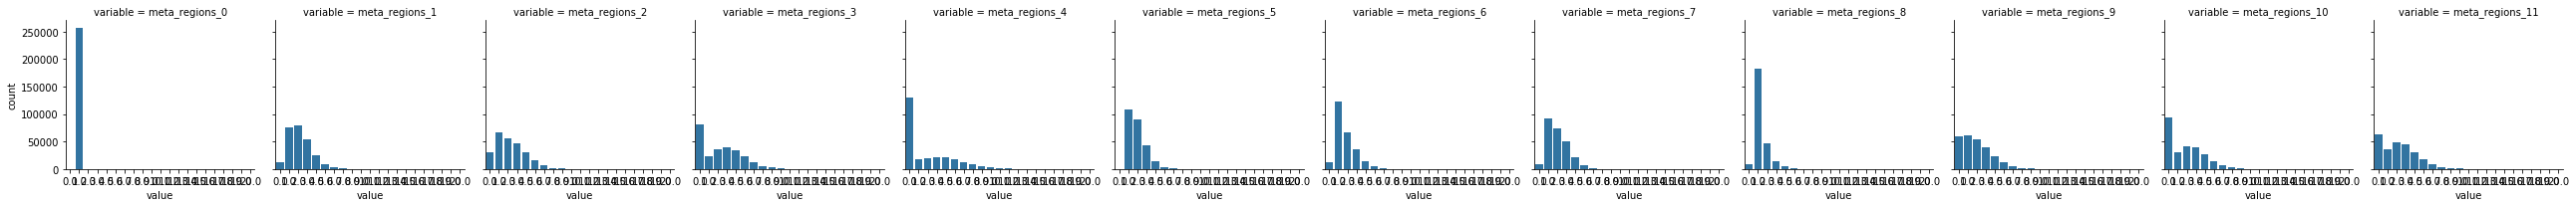

In [37]:
tmp = pandas.melt(df.reset_index(), id_vars=["idx"], value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

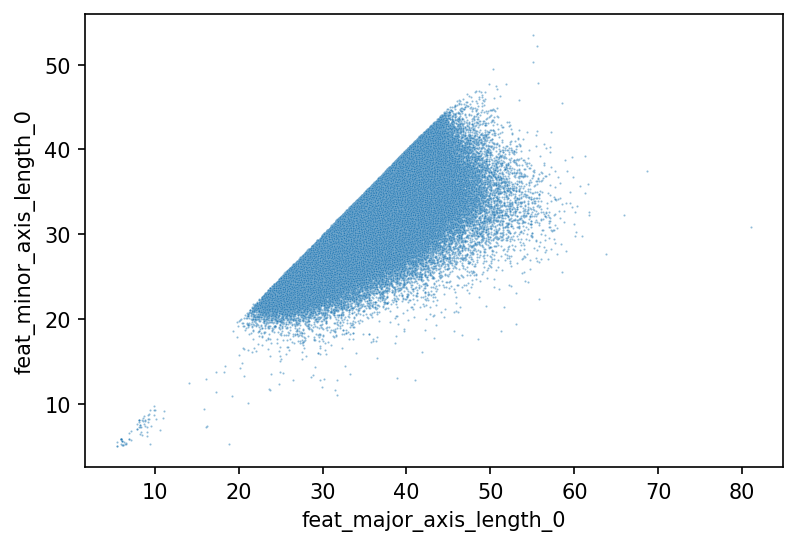

In [38]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_0", y="feat_minor_axis_length_0", s=1, alpha=0.5)

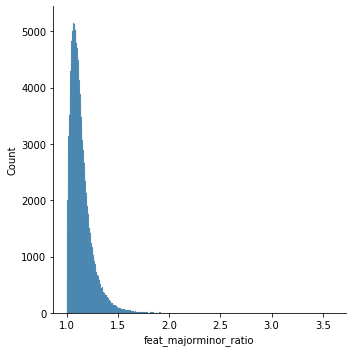

In [39]:
df["feat_majorminor_ratio"] = df["feat_major_axis_length_0"] / df["feat_minor_axis_length_0"]
ax = seaborn.displot(data=df, x="feat_majorminor_ratio")

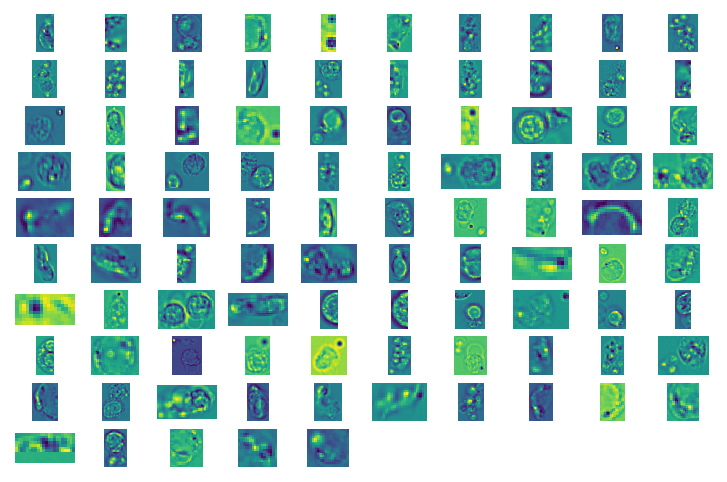

In [42]:
sel1 = df["feat_majorminor_ratio"] > 2
plot_gate_zarr(sel1, df)

In [43]:
df = df[~sel1]
df.shape

(257824, 617)

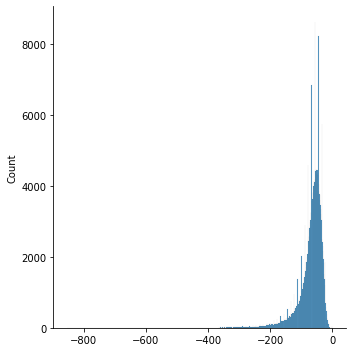

In [44]:
seaborn.displot(data=df["feat_area_0"] - df["feat_convex_area_0"])

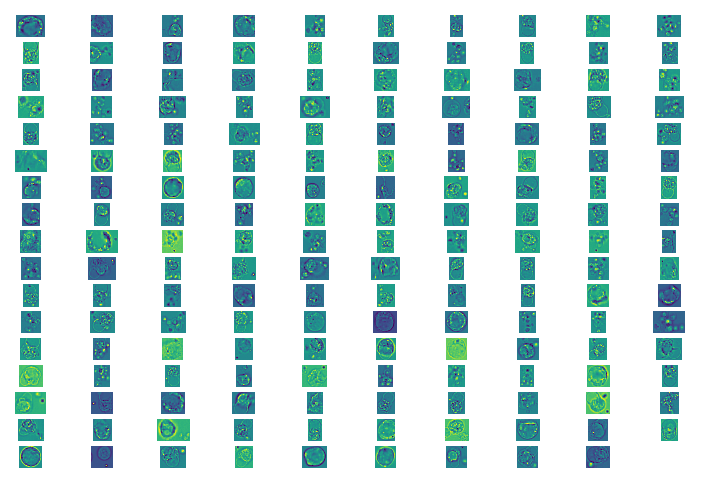

In [45]:
sel1 = (df["feat_area_0"] - df["feat_convex_area_0"]) < -400
core.plot_gate_zarr(sel1, df)

In [46]:
df = df[~sel1]
df.shape

(257655, 617)

/scratch/leuven/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


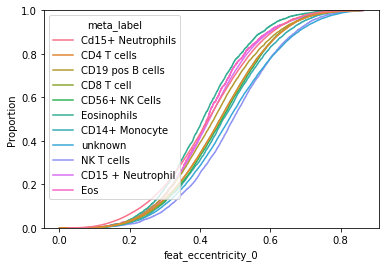

In [47]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_0", hue="meta_label")

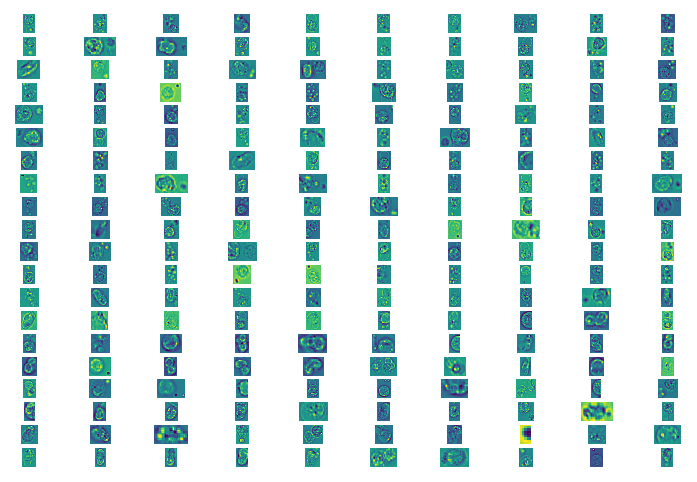

In [48]:
sel1 = df["feat_eccentricity_0"] > 0.8
core.plot_gate_zarr(sel1, df)

In [49]:
df = df[~sel1]
df.shape

(256831, 617)

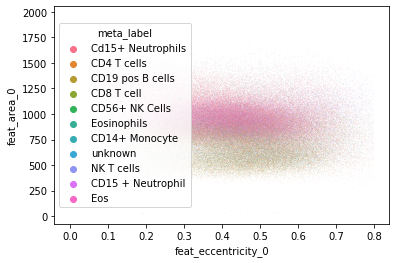

In [50]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_0", y="feat_area_0", s=0.1, alpha=0.5, hue="meta_label")

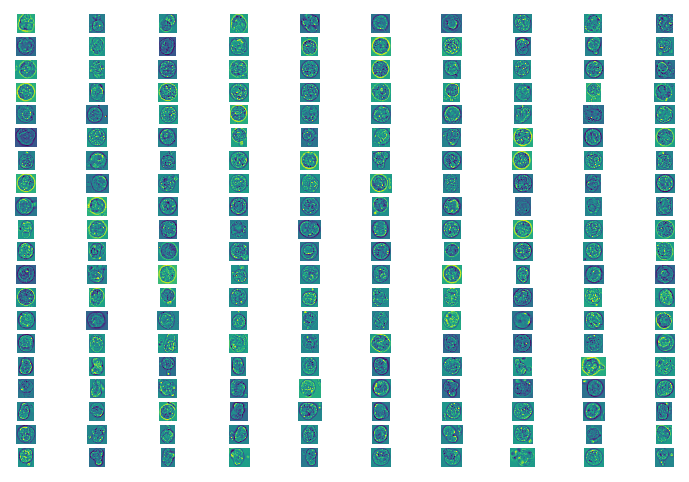

In [51]:
sel1 = df["feat_eccentricity_0"] > 0
sel2 = df["feat_area_0"] > 1500
core.plot_gate_zarr(sel1 & sel2, df)

In [220]:
df = df[~sel1]
df.shape

(118126, 408)

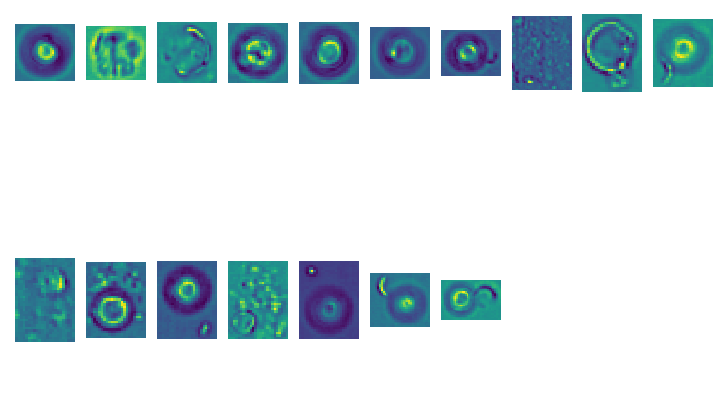

In [221]:
sel1 = df["feat_area_0"] > 500
sel2 = df["feat_eccentricity_0"] > 0.5
core.plot_gate_zarr(sel1 & sel2, df, sort="feat_eccentricity_0")

In [222]:
df = df[~(sel1 & sel2)]
df.shape

(118109, 408)

# Noisy events

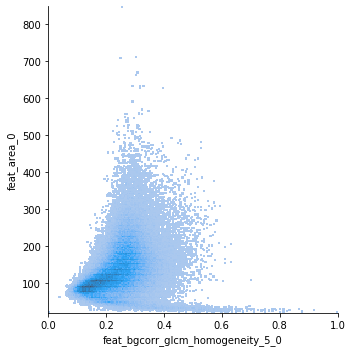

In [223]:
seaborn.displot(data=df, x="feat_bgcorr_glcm_homogeneity_5_0", y="feat_area_0")

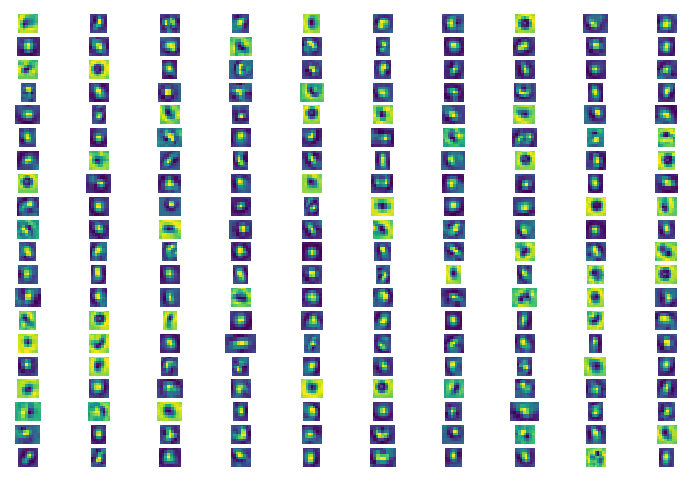

In [224]:
sel1 = df["feat_bgcorr_glcm_homogeneity_5_0"] > 0
sel2 = df["feat_area_0"] < 50
core.plot_gate_zarr(sel1 & sel2, df)

In [225]:
df = df[~(sel1 & sel2)]
df.shape

(114022, 408)

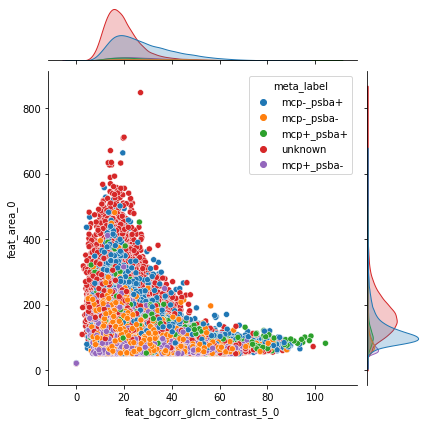

In [226]:
seaborn.jointplot(data=df, x="feat_bgcorr_glcm_contrast_5_0", y="feat_area_0", hue="meta_label")

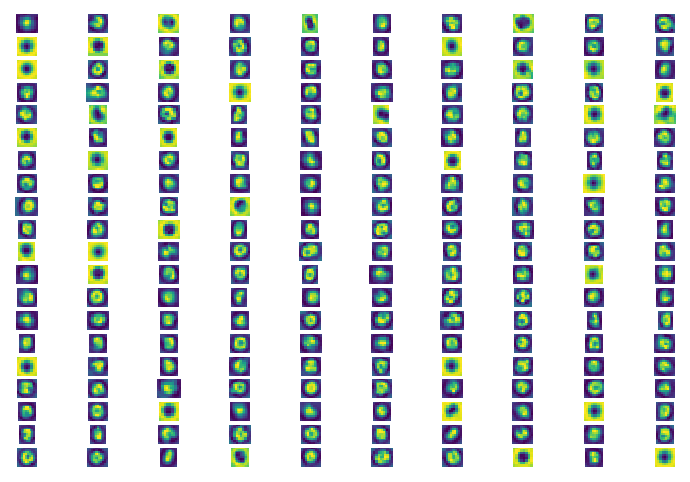

In [227]:
sel1 = df["feat_bgcorr_glcm_contrast_5_0"] > 60
core.plot_gate_zarr(sel1, df)

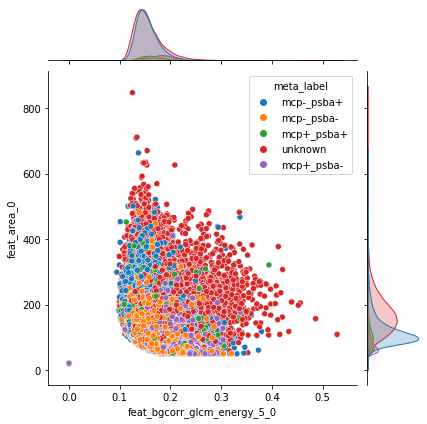

In [228]:
seaborn.jointplot(data=df, x="feat_bgcorr_glcm_energy_5_0", y="feat_area_0", hue="meta_label")

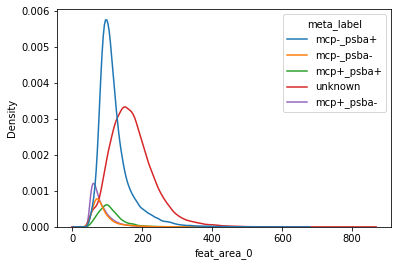

In [229]:
seaborn.kdeplot(data=df, x="feat_area_0", hue="meta_label")

In [230]:
df["meta_label"].value_counts()

unknown       53418
mcp-_psba+    45289
mcp+_psba-     6031
mcp+_psba+     4860
mcp-_psba-     4424
Name: meta_label, dtype: int64

# Distributions

In [52]:
df = df.drop(columns=df.filter(regex="feat").columns[df.filter(regex="feat").var().isna()])
df.shape

(256831, 617)

# Feature correlation

In [70]:
correlation = df.filter(regex="feat.*").corr()

## Overall feature correlation

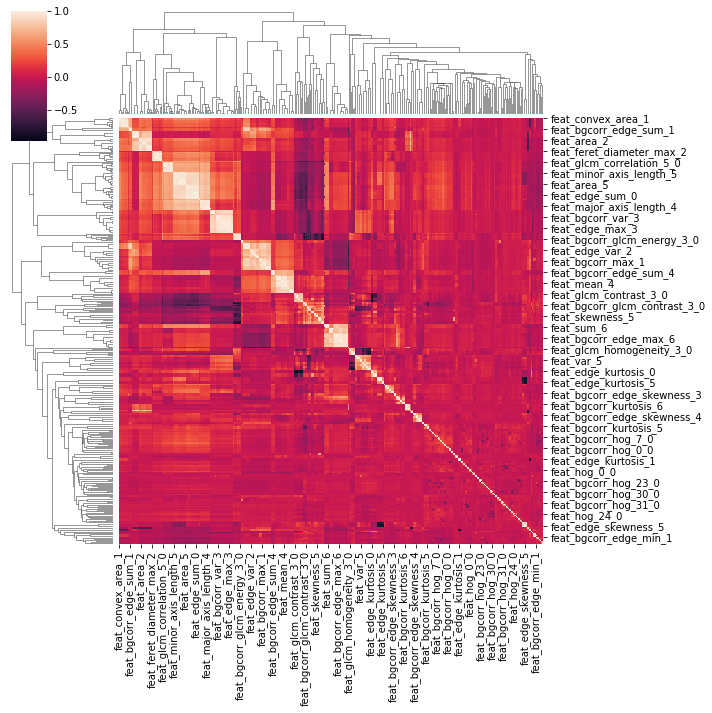

In [71]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

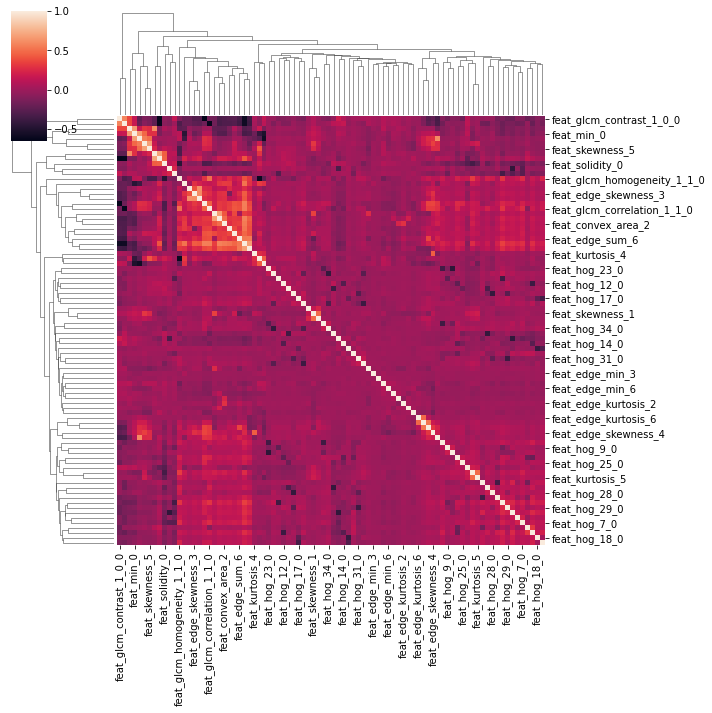

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [232]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202111161230/single_focused_index.npy", df.index.values)

In [53]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/results/scip/202111191528/columns.npy", df.columns.values)